# Notebook Regresion Lineal 1 Reto: Interlub
Author: A. Ramirez-Morales (andres.ramirez@tec.mx)


## Instrucciones:
- Complete las funciones donde vea líneas de código inconclusas
- Use comentarios para documentar de manera integral sus funciones
- Pruebe sus funciones con distintos parámetros
- Aumente las explicaciones en el Markdown y en el código
- Procure NO usar chatGPT ú otra tecnología similar, usted tiene la capacidad intelectual suficiente para resolverlo por usted mismo
- Use la documentación oficial de las librerías que se utilizan
- Se entrega un archivo PDF CANVAS como lo indique el profesor
- Active el kernel proveniente de `Anaconda`
- Complete las funciones donde vea líneas de código inconclusas
- Use comentarios para documentar de manera integral sus funciones
- Pruebe sus funciones con distintos parámetros
- Aumente las explicaciones en el Markdown y en el código
- Prohibido usar chatGPT ú otra tecnología similar, usted tiene la capacidad intelectual suficiente para resolverlo por usted mismo
- Use la documentación oficial de las librerías que se utilizan
- Se entrega un archivo PDF CANVAS como lo indique el profesor



In [1]:
# cargar librerías básicas
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro
import pandas as pd
import re   # <- Lo uso para tratar de procesar los rangos, como "265-295"

# 0. Datos disponibles

 Cargar los datos como pandas data frame

In [3]:
df = pd.read_csv('/Users/damian/Universidad/multivariados_ds/reto_andres/data/datos_grasas_Tec_limpio.csv')

Dele un vistazo a los datos (tambien abralos en excel)

In [4]:
def glimpse(df):
    """
    completar documentacion
    """
    print("Data Types:")
    print(df.dtypes)
    print("\nShape:", df.shape)
    print("\nFirst few rows:")
    print(df.head())


# llame a la funcion
glimpse(df)


Data Types:
idDatosGrasas                                 int64
codigoGrasa                                  object
Aceite Base                                  object
Espesante                                    object
Grado NLGI Consistencia                     float64
Viscosidad del Aceite Base a 40°C. cSt      float64
Penetración de Cono a 25°C, 0.1mm            object
Punto de Gota, °C                            object
Estabilidad Mecánica, %                      object
Punto de Soldadura Cuatro Bolas, kgf        float64
Desgaste Cuatro Bolas, mm                   float64
Indice de Carga-Desgaste                    float64
Carga Timken Ok, lb                          object
Resistencia al Lavado por Agua a 80°C, %     object
Corrosión al Cobre                           object
Registro NSF                                float64
Factor de Velocidad                         float64
Temperatura de Servicio °C, min               int64
Temperatura de Servicio °C, max               int64


## 1. Procesamiento de datos

### 1.1. Quitar columnas que no necesitamos
*Ejercicio:* Analice que columnas va a quitar, anote una justificación clara de por que esta quitando estas columnas

In [5]:
df_reduced = df.drop(
    [
        "codigoGrasa",          # identificador de grasa (no aporta a la regresión)
        "subtitulo",            # texto descriptivo/redudante
        "idDatosGrasas",        # identificador de registro (no es variable física)
        "descripcion",          # texto largo
        "beneficios",           # texto
        "categoria",            # categórica muy general, no la usaremos
        "Corrosión al Cobre",   # muy pocos datos / no usada en el modelo
        "Indice de Carga-Desgaste",  # muy incompleta / no usada
    ],
    axis=1
)

#### Justificar el por que nos desahacemos de una columna
- Motivo por que eliminar "codigoGrasas", ya que no aporta nada a la regresión.

### Justificación de las columnas eliminadas

Durante el preprocesamiento inicial se eliminaron varias columnas que no aportan valor al modelo de regresión lineal o que, por sus características, introducen ruido o redundancia. A continuación se explica el motivo de cada eliminación:

- **`codigoGrasa`**  
  Es simplemente un identificador interno del producto. No contiene información física ni química relevante y no tiene relación alguna con la variable objetivo. Mantenerla podría inducir al modelo a aprender patrones inexistentes.

- **`idDatosGrasas`**  
  Es otro identificador único generado por la base de datos. No representa una propiedad del producto ni aporta variabilidad útil para la regresión.

- **`subtitulo`**  
  Texto descriptivo de carácter comercial. No contiene información numérica ni categórica estructurada que permita incorporarla al modelo sin un procesamiento NLP especializado. Además, suele ser redundante con `descripcion`.

- **`descripcion`**  
  Campo de texto largo que describe comercialmente el producto. Para incluirlo correctamente se requeriría vectorización (TF-IDF, embeddings, etc.), lo cual está fuera del alcance del enfoque actual. Mantenerla como texto impediría convertir el dataset en 100% numérico.

- **`beneficios`**  
  Campo textual altamente redundante y no estructurado. Similar a `descripcion`, pero aún más variable entre productos. Introduciría ruido en un modelo numérico.

- **`categoria`**  
  Es una categoría extremadamente general (“Grasa”), sin variación relevante entre las observaciones. Al no aportar variabilidad, no contribuye a la regresión.

- **`Corrosión al Cobre`**  
  Contiene demasiados valores faltantes. Su baja cobertura haría que se elimine gran parte de las filas o genere demasiados `-99`, degradando la calidad del modelo.

- **`Indice de Carga-Desgaste`**  
  Variable casi completamente vacía o muy incompleta. Su uso no sería estadísticamente válido y solo introduciría ruido.


### 1.2. Definir una funcion para mapear las variables categoricas
*Ejercicio*: Complete la función de tal manera que genere etiquetas del 0 a $n$ (donde $n$) es el numero de diferentes variables

In [6]:
cat_cols = ["Aceite Base", "Espesante", "color", "textura"]

for col in cat_cols:
    print(f"\n=== {col} ===")
    print(df_reduced[col].value_counts(dropna=False))


=== Aceite Base ===
Aceite Base
Mineral HT          20
Mineral USP         11
Mineral              8
NaN                  4
Semi-Sintetico       3
Mineral HC           3
Mineral Refinado     2
Name: count, dtype: int64

=== Espesante ===
Espesante
Complejo Sulfonato de Calcio       18
Complejo de Aluminio - Poliurea     6
Complejo de Aluminio                6
NaN                                 6
Complejo de Poliurea                6
Complejo de Litio                   5
Silica                              2
Bentonita                           2
Name: count, dtype: int64

=== color ===
color
Beige          17
Negro          12
Blanco         10
Ambar           6
CafÃ© Claro     2
Cristalino      2
CafÃ©           1
Beige Claro     1
Name: count, dtype: int64

=== textura ===
textura
Suave                26
Adherente            20
Suave Adherente       3
Suave Adhesiva        1
Viscosa adherente     1
Name: count, dtype: int64


In [7]:
def show_category_summary(df, cat_cols):
    """
    Muestra las frecuencias de cada categoría en un conjunto de columnas categóricas.
    """
    for col in cat_cols:
        print(f"\n=== {col} ===")
        print(df[col].value_counts(dropna=False))

# Usar la función
show_category_summary(df_reduced, cat_cols)


=== Aceite Base ===
Aceite Base
Mineral HT          20
Mineral USP         11
Mineral              8
NaN                  4
Semi-Sintetico       3
Mineral HC           3
Mineral Refinado     2
Name: count, dtype: int64

=== Espesante ===
Espesante
Complejo Sulfonato de Calcio       18
Complejo de Aluminio - Poliurea     6
Complejo de Aluminio                6
NaN                                 6
Complejo de Poliurea                6
Complejo de Litio                   5
Silica                              2
Bentonita                           2
Name: count, dtype: int64

=== color ===
color
Beige          17
Negro          12
Blanco         10
Ambar           6
CafÃ© Claro     2
Cristalino      2
CafÃ©           1
Beige Claro     1
Name: count, dtype: int64

=== textura ===
textura
Suave                26
Adherente            20
Suave Adherente       3
Suave Adhesiva        1
Viscosa adherente     1
Name: count, dtype: int64


In [8]:
# Aquí trato de "limpiar" las columnas numericas que tienen rangos como "265-295", strings o cualquier cosa rara
def convert_range_to_numeric(x):
    if isinstance(x, str):
        # En caso de que sean rangos:
        match = re.match(r"(\d+)\s*-\s*(\d+)", x)
        if match:
            low, high = match.groups()
            return (float(low) + float(high)) / 2.0
        # En caso de que sea número "suelto"
        try:
            return float(x)
        except ValueError:
            return np.nan
    return x

cols_to_fix = [
    "Penetración de Cono a 25°C, 0.1mm",
    "Punto de Gota, °C",
    "Estabilidad Mecánica, %",
    "Carga Timken Ok, lb",
    "Resistencia al Lavado por Agua a 80°C, %",
]

for col in cols_to_fix:
    if col in df_reduced.columns:
        df_reduced[col] = df_reduced[col].apply(convert_range_to_numeric)


In [9]:
def encode_categoricals(df, cat_cols, na_value=-99):
    """
    Convierte columnas categóricas en valores numéricos usando pandas.Categorical.
    Devuelve el DataFrame transformado y un diccionario con los mapeos.
    """
    mappings = {}
    for col in cat_cols:
        cat = pd.Categorical(df[col])
        df[col] = cat.codes   # -1 para NaN
        mappings[col] = dict(enumerate(cat.categories))
        print(f"\nColumna '{col}' codificada. Categorías encontradas:")
        print(mappings[col])

# Acá reemplazamos en el código -1 (faltantes) por -99, nuestro valor sentinela.
    df[cat_cols] = df[cat_cols].replace(-1, na_value)
    return df, mappings
df_reduced, mappings = encode_categoricals(df_reduced, cat_cols)


Columna 'Aceite Base' codificada. Categorías encontradas:
{0: 'Mineral', 1: 'Mineral HC', 2: 'Mineral HT', 3: 'Mineral Refinado', 4: 'Mineral USP', 5: 'Semi-Sintetico'}

Columna 'Espesante' codificada. Categorías encontradas:
{0: 'Bentonita', 1: 'Complejo Sulfonato de Calcio', 2: 'Complejo de Aluminio', 3: 'Complejo de Aluminio - Poliurea', 4: 'Complejo de Litio', 5: 'Complejo de Poliurea', 6: 'Silica'}

Columna 'color' codificada. Categorías encontradas:
{0: 'Ambar', 1: 'Beige', 2: 'Beige Claro', 3: 'Blanco', 4: 'CafÃ©', 5: 'CafÃ© Claro', 6: 'Cristalino', 7: 'Negro'}

Columna 'textura' codificada. Categorías encontradas:
{0: 'Adherente', 1: 'Suave', 2: 'Suave Adherente', 3: 'Suave Adhesiva', 4: 'Viscosa adherente'}


### 1.3 Pasos finales
- Llenar de -99 donde no hayan registros
- Guardar en archivo csv


In [10]:
# Guardar el DataFrame transformado en un nuevo CSV
output_path = "transformed_data_interlub.csv"
df_reduced = df_reduced.fillna(-99)   # cualquier NaN restante pasa a -99 (missing)
df_reduced.to_csv(output_path, index=False)
print(f"Archivo guardado con nulos reemplazados por -99 en '{output_path}'.")

Archivo guardado con nulos reemplazados por -99 en 'transformed_data_interlub.csv'.


# 2. Generar datos
*Ejercicio:* comprenda, complete y documente la siguiente funcion, el profesor le va apoyar

In [11]:

def simular_datos(df_original, n_nuevos=50):
    """
    completar documentacion
    esta funcion esta incompleta, completar las lineas
    """

    """
    Generamos n_nuevos registros sintéticos a partir de df_original.
    - Seleccionamos al azar una fila base.
    - Si el valor es -99 (missing), lo conserva como -99.
    - Si el valor es válido, hace pequeñas variaciones según el tipo de variable.
    Devuelve un DataFrame con los nuevos registros.
    """

    nuevos_datos = []
    
    for i in range(n_nuevos):
        # seleccionar una grasa base aleatoria
        grasa_base = df_original.iloc[np.random.randint(0, len(df_original))]
        
        nuevo_id = len(df_original) + i
        
        # nuevo grasa con variaciones controladas
        nuevo_registro = {}
        
        for col in df_original.columns: # iteramos sobre cada columna
            if col == '':  # mandamos a volar el indice (obvio)
                continue
                
            valor_base = grasa_base[col]
            
            # si -99, lo seguimos manteniendo como missing (esto lo podemos cambiar)
            if valor_base == -99:
                nuevo_registro[col] = -99
            else:
                # variacion segun el tipo de variable
                if col in ['Aceite Base', 'Espesante', 'color', 'textura']:
                    # variables categoricas, las dejamos igual... por el momento
                    nuevo_registro[col] = valor_base
                elif col in ['Grado NLGI Consistencia']:
                    # NLGI posibles valores
                    nlgi_opciones = [0, 1, 1.5, 2, 2.5, 3]
                    nuevo_registro[col] = np.random.choice(nlgi_opciones)
                elif col in ['Viscosidad del Aceite Base a 40°C. cSt']:
                    # viscosidad con variacion de 15% (esto puede cambiar)
                    nuevo_registro[col] = valor_base * np.random.uniform(0.85, 1.15)
                elif col in ['Penetración de Cono a 25°C, 0.1mm']:
                    # penetracion con variación 5% (esto puede cambiar)
                    nuevo_registro[col] = valor_base * np.random.uniform(0.95, 1.05)
                elif col in ['Punto de Gota, °C']:
                    # punt de gota con variación 3% (esto puede cambiar)
                    nuevo_registro[col] = valor_base * np.random.uniform(0.97, 1.03)
                # completar el codigo desde aqui
                elif col in ['Punto de Soldadura Cuatro Bolas, kgf']:
                    # variación de ±10% en la carga de soldadura
                    nuevo_registro[col] = valor_base * np.random.uniform(0.90, 1.10)

                elif col in ['Desgaste Cuatro Bolas, mm']:
                    # desgaste con pequeña variación (±10%)
                    nuevo_registro[col] = valor_base * np.random.uniform(0.90, 1.10)

                elif col in ['Resistencia al Lavado por Agua a 80°C, %',
                             'Estabilidad Mecánica, %']:
                    # propiedades en % con variación moderada (±5%)
                    nuevo_registro[col] = valor_base * np.random.uniform(0.95, 1.05)

                elif col in ['Factor de Velocidad']:
                    # factor de velocidad con variación de ±10%
                    nuevo_registro[col] = valor_base * np.random.uniform(0.90, 1.10)

                elif col in ['Temperatura de Servicio °C, min',
                             'Temperatura de Servicio °C, max']:
                    # temperaturas de servicio con variación discreta de ±5 °C
                    nuevo_registro[col] = valor_base + np.random.randint(-5, 6)
               
                # aqui termina su participacion en este codigo y la vie ;)
                elif col in ['Registro NSF']:
                    # algunos como -99 (faltantes)
                    if np.random.random() < 0.7:
                        nuevo_registro[col] = -99
                    else:
                        nuevo_registro[col] = np.random.uniform(100000, 200000)
                else:
                    nuevo_registro[col] = valor_base
        
        nuevos_datos.append(nuevo_registro)
    
    return pd.DataFrame(nuevos_datos)

### 2.1 Llamar a la funcion 

In [12]:
df_reduced_numer = df_reduced.copy()
for col in cat_cols:
    df_reduced_numer[col] = pd.to_numeric(df_reduced_numer[col], errors='coerce') 
# glimpse(df_reduced)
# Columnas numéricas que la función simular_datos trata como números
numeric_cols = [
    'Grado NLGI Consistencia',
    'Viscosidad del Aceite Base a 40°C. cSt',
    'Penetración de Cono a 25°C, 0.1mm',
    'Punto de Gota, °C',
    'Punto de Soldadura Cuatro Bolas, kgf',
    'Desgaste Cuatro Bolas, mm',
    'Resistencia al Lavado por Agua a 80°C, %',
    'Estabilidad Mecánica, %',
    'Factor de Velocidad',
    'Temperatura de Servicio °C, min',
    'Temperatura de Servicio °C, max',
    'Registro NSF',
]

for col in numeric_cols:
    if col in df_reduced_numer.columns:
        df_reduced_numer[col] = pd.to_numeric(df_reduced_numer[col], errors='coerce')

# por si se generó algún NaN al convertir:
df_reduced_numer = df_reduced_numer.fillna(-99)
expanded_data = simular_datos(df_reduced_numer, n_nuevos=100)
df_reduced = pd.concat([df_reduced, expanded_data], ignore_index=True)

# dele un vistazo a los datos
glimpse(df_reduced)
# guarde los datos en un archivo csv
output_path = "expanded_data_interlub.csv"
df_reduced.to_csv(output_path, index=False)
print(f"Archivo guardado con datos expandidos en '{output_path}'.")

Data Types:
Aceite Base                                   int64
Espesante                                     int64
Grado NLGI Consistencia                     float64
Viscosidad del Aceite Base a 40°C. cSt      float64
Penetración de Cono a 25°C, 0.1mm           float64
Punto de Gota, °C                           float64
Estabilidad Mecánica, %                     float64
Punto de Soldadura Cuatro Bolas, kgf        float64
Desgaste Cuatro Bolas, mm                   float64
Carga Timken Ok, lb                         float64
Resistencia al Lavado por Agua a 80°C, %    float64
Registro NSF                                float64
Factor de Velocidad                         float64
Temperatura de Servicio °C, min               int64
Temperatura de Servicio °C, max               int64
aplicaciones                                 object
color                                          int8
textura                                        int8
dtype: object

Shape: (151, 18)

First few rows:
   

# 3. Regresión lineal

### 3.1 Variables en el modelo (y, X)
*Ejercicio:* Analice y entienda el uso de la siguiente funcion, documentela adecuadamente.


In [19]:

def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """

    """
    Prepara X (predictoras), y (objetivo) para la regresión lineal:
    - Filtramos todas las filas donde alguna de las variables (X o y) sea -99
      (O sea, datos faltantes codificados).
    - Devuelve X, y listas para escalar y modelar.
    """
    cols = variables_predictoras + [variable_objetivo]

    df_num = df[cols].apply(pd.to_numeric, errors="coerce")
    
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y

### 3.2 Definir el modelo

*Ejercicio:* complete y comente las siguientes lineas de codigo

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 1. Leer los datos expandidos
expanded_data = pd.read_csv("/Users/damian/Universidad/multivariados_ds/reto_andres/notebooks/expanded_data_interlub.csv")

# 2. Definir variable objetivo
variable_objetivo = "Punto de Soldadura Cuatro Bolas, kgf"

# 3. Definir variables predictoras
variables_predictoras = [
    "Grado NLGI Consistencia",
    "Viscosidad del Aceite Base a 40°C. cSt",
    "Penetración de Cono a 25°C, 0.1mm",
    "Punto de Gota, °C",
    "Estabilidad Mecánica, %",
    "Factor de Velocidad",
    "Aceite Base",
    "Espesante",
    "color",
    "textura"
]

# 4. Función para separar X e y
def variables_regresion(df, objetivo, predictores):
    # Nos aseguramos de que todo sea numérico
    X = df[predictores].apply(pd.to_numeric, errors="coerce").fillna(-99)
    y = df[objetivo].apply(pd.to_numeric, errors="coerce").fillna(-99)
    return X, y

# 5. Preparar X, y
X, y = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)

print("Shape de X:", X.shape)
print("Shape de y:", y.shape)

test_size = 0.2  # 20% para prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42
)

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo lineal
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)

# Métricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"MSE (train): {mse_train:.3f}")
print(f"MSE (test) : {mse_test:.3f}")
print(f"R²  (train): {r2_train:.3f}")
print(f"R²  (test) : {r2_test:.3f}")

Shape de X: (151, 10)
Shape de y: (151,)
MSE (train): 14994.034
MSE (test) : 19633.818
R²  (train): 0.673
R²  (test) : 0.615


### 3.2 Grafica de resultados

*Ejercicio:* analice e interprete la grafica resultante

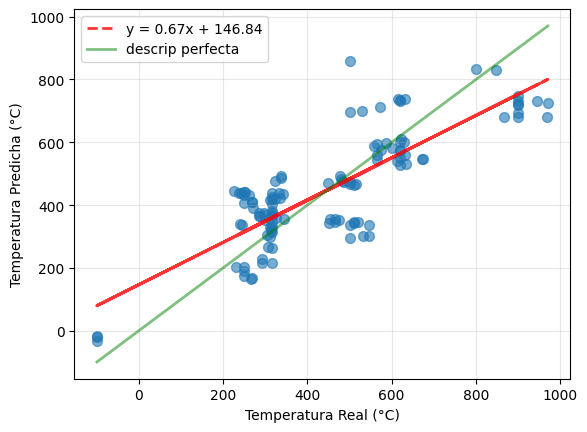

In [21]:
# graficar
y_pred = y_pred_train
y_real = y_train
    
# linea de regresión para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)